<a href="https://colab.research.google.com/github/sharon-kurant/VCE_Remission_Classification/blob/main/lewis_logistic_regression_youdens_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve
)

In [ ]:
# ============== STEP 1: DEFINE FUNCTION TO EXTRACT FEATURES ==============
def extract_features_from_video(data, filename, window_size=100, stricture_threshold=0.7):
    """
    Given a single video's data (DataFrame) and other parameters,
    extract a variety of features and return them in a dictionary.
    """
    features = {}

    # Calculate simple statistics for each class probability
    class_columns = ['normal', 'ulcer', 'stricture']
    for cls in class_columns:
        features[f"{cls}_mean"] = data[cls].mean()
        features[f"{cls}_std"] = data[cls].std()
        features[f"{cls}_min"] = data[cls].min()
        features[f"{cls}_max"] = data[cls].max()
        features[f"{cls}_median"] = data[cls].median()

    # Proportion of frames for each predicted class
    predicted_counts = data['predicted_class'].value_counts(normalize=True)
    for cls in class_columns:
        features[f"{cls}_predicted_proportion"] = predicted_counts.get(cls, 0)

    # Frame-to-frame changes (differences)
    for cls in class_columns:
        diffs = data[cls].diff().dropna()
        features[f"{cls}_diff_mean"] = diffs.mean()
        features[f"{cls}_diff_std"] = diffs.std()

    # Aggregate predicted class counts
    total_frames = len(data)
    for cls in class_columns:
        features[f"{cls}_frame_count"] = (data['predicted_class'] == cls).sum()
        features[f"{cls}_frame_proportion"] = (data['predicted_class'] == cls).sum() / total_frames

    # Sliding window feature extraction
    half_window = window_size // 2
    n_frames = len(data)

    # Initialize arrays for sliding window stats
    avg_stricture = np.zeros(n_frames)
    max_stricture = np.zeros(n_frames)
    var_stricture = np.zeros(n_frames)
    count_high_stricture = np.zeros(n_frames)
    avg_ulcer = np.zeros(n_frames)

    for i in range(0, n_frames, 50):
        start = max(0, i - half_window)
        end = min(n_frames, i + half_window + 1)

        window = data.iloc[start:end]
        stricture_probs = window['stricture']
        ulcer_probs = window['ulcer']

        avg_stricture[i] = stricture_probs.mean()
        max_stricture[i] = stricture_probs.max()
        var_stricture[i] = stricture_probs.var()
        count_high_stricture[i] = (stricture_probs > stricture_threshold).sum()
        avg_ulcer[i] = ulcer_probs.mean()

    # Aggregate sliding window features
    features['Avg_Stricture_Window'] = avg_stricture.mean()
    features['Max_Stricture_Window'] = max_stricture.max()
    features['Var_Stricture_Window'] = var_stricture.mean()
    features['Count_High_Stricture_Window'] = count_high_stricture.sum()
    features['Avg_Ulcer_Window'] = avg_ulcer.mean()

    # Add filename
    features["filename"] = filename

    return features


In [ ]:
# ============== STEP 2: PROCESS ALL VIDEOS ==============
def process_all_videos(classification_path, targets_table):
    """
    Loop over CSVs in classification_path, extract features,
    and match each CSV to the corresponding target row in targets_table.
    """
    all_features = []

    for filename in os.listdir(classification_path):
        if filename.endswith(".csv"):
            filepath = os.path.join(classification_path, filename)
            video_data = pd.read_csv(filepath)

            # Extract features
            video_features = extract_features_from_video(video_data, filename)

            # Match the target by filename
            video_name = os.path.splitext(filename)[0]
            # If your actual CSV filename structure differs, adjust the extraction logic here
            video_name = video_name.split('_')[0]

            target_row = targets_table[targets_table['Filename'] == video_name]

            if not target_row.empty:
                # We'll temporarily store the raw "LS Highest" here; we'll apply thresholds later
                video_features['raw_lewis_score'] = target_row['LS Highest'].values[0]
            else:
                video_features['raw_lewis_score'] = np.nan

            all_features.append(video_features)

    features_df = pd.DataFrame(all_features)
    return features_df


In [ ]:
# ============== STEP 3: LOAD DATA & EXTRACT FEATURES ==============
classification_path = "/content/drive/MyDrive/remission/results/videos_stills_classifications"
targets_table = pd.read_csv('/content/drive/MyDrive/remission/videos/video_md.csv')

features_df = process_all_videos(classification_path, targets_table)
print("Extracted Feature DataFrame (first 5 rows):")
features_df.head()

Extracted Feature DataFrame (first 5 rows):


,normal_mean,normal_std,normal_min,normal_max,normal_median,ulcer_mean,ulcer_std,ulcer_min,ulcer_max,ulcer_median,...,ulcer_frame_proportion,stricture_frame_count,stricture_frame_proportion,Avg_Stricture_Window,Max_Stricture_Window,Var_Stricture_Window,Count_High_Stricture_Window,Avg_Ulcer_Window,filename,raw_lewis_score
0,0.661437,0.276132,0.065863,0.965700,0.786730,0.035587,0.022875,0.008791,0.184523,0.028294,...,0.000000,0,0.00000,0.000732,0.301568,0.000019,0.0,0.000720,00HOqg33_stills.csv,300
1,0.715532,0.225160,0.072954,0.969101,0.810281,0.050539,0.049091,0.007710,0.606865,0.034952,...,0.003502,303,0.04614,0.001487,0.658083,0.000078,0.0,0.001017,05mgNg33_stills.csv,4072
2,0.542111,0.298530,0.040925,0.959767,0.611944,0.037038,0.021722,0.007745,0.156819,0.030929,...,0.000000,0,0.00000,0.000938,0.334498,0.000019,0.0,0.000738,0R4HoQ33_stills.csv,225
3,0.503323,0.262728,0.048222,0.963681,0.507162,0.046137,0.028873,0.006009,0.349847,0.038846,...,0.000000,0,0.00000,0.000864,0.343409,0.000015,0.0,0.000927,138S0g33_stills.csv,450
4,0.555038,0.284026,0.055388,0.966182,0.615422,0.037693,0.022874,0.005598,0.428292,0.032044,...,0.000000,0,0.00000,0.000683,0.334345,0.000010,0.0,0.000757,171fWw33_stills.csv,225


In [ ]:
# ============== STEP 4: TEST MULTIPLE THRESHOLDS ==============
candidate_thresholds = [150, 350, 500, 650, 800, 950, 1200, 1500, 1800, 2000]

# We'll store results in a list for comparison
results = []

# Grid search parameters for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': ['balanced', None],
    'solver': ['liblinear', 'lbfgs']
}

for ls_threshold in candidate_thresholds:
    df_threshold = features_df.copy()
    # Define the binary target using the candidate threshold
    df_threshold['lewis_score'] = (df_threshold['raw_lewis_score'] > ls_threshold).astype(int)

    X = df_threshold.drop(columns=['filename', 'raw_lewis_score', 'lewis_score'])
    y = df_threshold['lewis_score']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=1, stratify=y
    )

    # ============== (A) Train Logistic Regression with GridSearch ==============
    logreg = LogisticRegression(max_iter=1000)
    grid_search = GridSearchCV(
        logreg,
        param_grid,
        scoring='roc_auc',
        cv=5,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Evaluate default threshold=0.5
    y_pred_default = best_model.predict(X_test)  # calls threshold=0.5 internally
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    accuracy_default = accuracy_score(y_test, y_pred_default)
    precision_default = precision_score(y_test, y_pred_default, zero_division=0)
    recall_default = recall_score(y_test, y_pred_default)
    f1_default = f1_score(y_test, y_pred_default)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # ============== (B) Find Youden-Optimal Threshold ==============
    # 1. Get the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # 2. Compute Youden's Index = TPR + TNR - 1 = TPR - FPR
    youden_values = tpr - fpr
    max_idx = np.argmax(youden_values)
    youden_optimal_threshold = thresholds[max_idx]
    best_youden = youden_values[max_idx]

    # 3. Predict again using the Youden-optimal threshold
    y_pred_youden = (y_pred_proba >= youden_optimal_threshold).astype(int)

    # 4. Compute metrics at that threshold
    accuracy_youden = accuracy_score(y_test, y_pred_youden)
    precision_youden = precision_score(y_test, y_pred_youden, zero_division=0)
    recall_youden = recall_score(y_test, y_pred_youden)
    f1_youden = f1_score(y_test, y_pred_youden)
    roc_auc_youden = roc_auc_score(y_test, y_pred_youden)

    # 5. Optional: You can also compute the confusion matrix to get the actual TNR, TPR, etc.
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_youden).ravel()
    specificity_youden = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity_youden = tp / (tp + fn) if (tp + fn) > 0 else 0
    # This should match tpr[max_idx], but it's illustrative to confirm.

    # Store all metrics in your results
    results.append({
        'LS_Threshold': ls_threshold,
        'Best_LogReg_Params': grid_search.best_params_,
        'ROC_AUC': roc_auc,

        # Default threshold = 0.5 metrics
        'Accuracy_0.5': accuracy_default,
        'Precision_0.5': precision_default,
        'Recall_0.5': recall_default,
        'F1_0.5': f1_default,

        # Youden-based threshold metrics
        'Youden_Optimal_Threshold': youden_optimal_threshold,
        'Youden_Index': best_youden,
        'Accuracy_Youden': accuracy_youden,
        'Precision_Youden': precision_youden,
        'Recall_Youden': recall_youden,
        'F1_Youden': f1_youden,
        'Sensitivity_Youden': sensitivity_youden,
        'Specificity_Youden': specificity_youden,
        'ROC_AUC_Youden': roc_auc_youden
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print("\nResults DataFrame:")
print(results_df)

# Identify best thresholds under various metrics — for demonstration:
best_auc_idx = results_df['ROC_AUC'].idxmax()
best_auc_threshold = results_df.loc[best_auc_idx, 'LS_Threshold']
print("\nBest LS Threshold for AUC:", best_auc_threshold)

best_youden_idx = results_df['Youden_Index'].idxmax()
best_youden_ls_threshold = results_df.loc[best_youden_idx, 'LS_Threshold']
best_youden_value = results_df.loc[best_youden_idx, 'Youden_Index']
print(f"Best LS Threshold for Youden’s Index: {best_youden_ls_threshold} with index={best_youden_value:.3f}")


Results DataFrame:
   LS_Threshold                                 Best_LogReg_Params   ROC_AUC  \
0           150  {'C': 100, 'class_weight': None, 'solver': 'lb...  0.724113   
1           350  {'C': 1, 'class_weight': None, 'solver': 'lbfgs'}  0.788378   
2           500  {'C': 0.1, 'class_weight': 'balanced', 'solver...  0.903050   
3           650  {'C': 0.1, 'class_weight': 'balanced', 'solver...  0.945312   
4           800  {'C': 0.1, 'class_weight': None, 'solver': 'li...  0.916380   
5           950  {'C': 0.01, 'class_weight': None, 'solver': 'l...  0.857614   
6          1200  {'C': 0.01, 'class_weight': None, 'solver': 'l...  0.841518   
7          1500  {'C': 0.01, 'class_weight': None, 'solver': 'l...  0.973060   
8          1800  {'C': 0.01, 'class_weight': None, 'solver': 'l...  0.829096   
9          2000  {'C': 0.01, 'class_weight': None, 'solver': 'l...  0.890756   

   Accuracy_0.5  Precision_0.5  Recall_0.5    F1_0.5  \
0      0.766129       0.798165    0.925532 

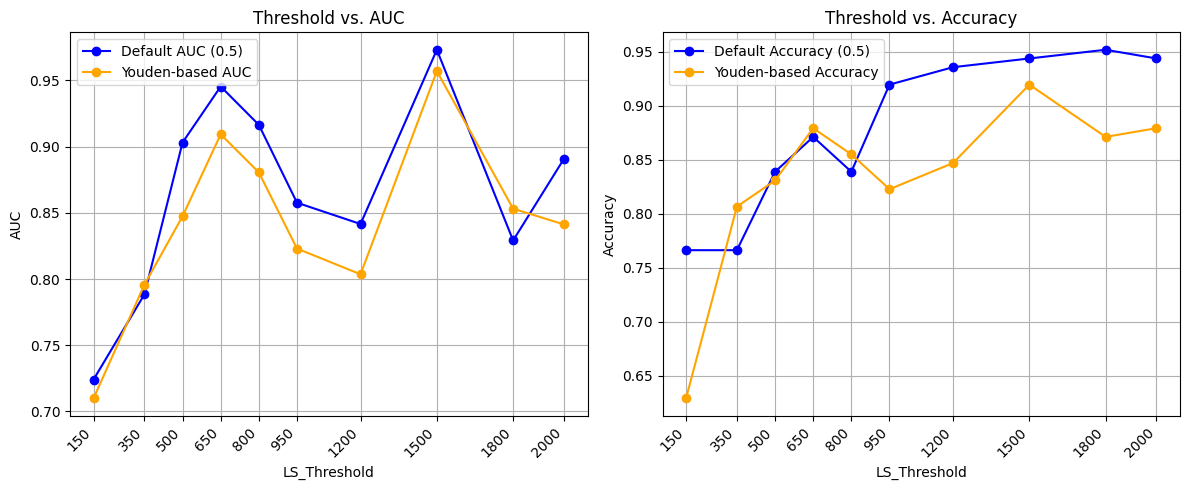

In [ ]:
import matplotlib.pyplot as plt

# ============== COMBINED AUC AND ACCURACY PLOTS ==============
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# -----------------------------------------------
# (1) AUC Subplot: Default AUC vs. Youden-based AUC
# -----------------------------------------------
axes[0].plot(results_df['LS_Threshold'], results_df['ROC_AUC'],
             marker='o', color='blue', label='Default AUC (0.5)')

axes[0].plot(results_df['LS_Threshold'], results_df['ROC_AUC_Youden'],
             marker='o', color='orange', label='Youden-based AUC')

axes[0].set_title('Threshold vs. AUC')
axes[0].set_xlabel('LS_Threshold')
axes[0].set_ylabel('AUC')
axes[0].grid(True)
axes[0].legend()

# Annotate points for Default AUC
# for x, y in zip(results_df['LS_Threshold'], results_df['ROC_AUC']):
#     axes[0].text(x, y, str(x), ha='center', va='bottom', fontsize=8, color='darkblue')

# # Annotate points for Youden-based AUC
# for x, y in zip(results_df['LS_Threshold'], results_df['ROC_AUC_Youden']):
#     axes[0].text(x, y, str(x), ha='center', va='top', fontsize=8, color='darkgreen')

# Rotate X-axis labels
axes[0].set_xticks(results_df['LS_Threshold'])
axes[0].set_xticklabels(results_df['LS_Threshold'], rotation=45, ha='right')


# -----------------------------------------------
# (2) Accuracy Subplot: Default Accuracy vs. Youden-based Accuracy
# -----------------------------------------------
axes[1].plot(results_df['LS_Threshold'], results_df['Accuracy_0.5'],
             marker='o', color='blue', label='Default Accuracy (0.5)')

axes[1].plot(results_df['LS_Threshold'], results_df['Accuracy_Youden'],
             marker='o', color='orange', label='Youden-based Accuracy')

axes[1].set_title('Threshold vs. Accuracy')
axes[1].set_xlabel('LS_Threshold')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)
axes[1].legend()

# Annotate points for Default Accuracy
# for x, y in zip(results_df['LS_Threshold'], results_df['Accuracy_0.5']):
#     axes[1].text(x, y, str(x), ha='center', va='bottom', fontsize=8, color='brown')

# # Annotate points for Youden-based Accuracy
# for x, y in zip(results_df['LS_Threshold'], results_df['Accuracy_Youden']):
#     axes[1].text(x, y, str(x), ha='center', va='top', fontsize=8, color='darkred')

# Rotate X-axis labels
axes[1].set_xticks(results_df['LS_Threshold'])
axes[1].set_xticklabels(results_df['LS_Threshold'], rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [ ]:
# results_df.to_csv('lewis_threshold_grid_search_results.csv', index=False)